In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
from hashlib import sha256
import pickle
from hmac import HMAC

In [2]:
def str_to_bytes(string):
    return string.encode('utf-8')

def int_to_bytes(x):
    return x.to_bytes(blocksize, order)

def bytes_to_int(x_bytes):
    return int.from_bytes(x_bytes, order)

def hmac_sha256(key, data):
    k_xor_opad, k_xor_ipad = bytearray(), bytearray()
    if len(key) < blocksize:
        key = zero_byte.to_bytes(blocksize-len(key), order) + key
    for i in range(blocksize):
        k_xor_opad.append(key[i] ^ 0x5c)
        k_xor_ipad.append(key[i] ^ 0x36)
    return sha256(k_xor_opad + sha256(k_xor_ipad + data).digest()).digest()

def hkdf_extract(xts, skm):
    return hmac_sha256(xts, skm)

def hkdf_expand(prk, last_key, ctx, i):
    return hmac_sha256(prk, last_key + ctx + int_to_bytes(i-1))

In [3]:
def generate_keys(xts, skm, ctx, number_of_iterations):
    keys = []
    keys.append(str_to_bytes(''))
    prk = hkdf_extract(xts, skm)
    for i in range(1, number_of_iterations):
        key_i = hkdf_expand(prk, keys[i-1], ctx, i)
        keys.append(key_i)
    return keys[1:]

def extract_first_5_bits_from_key(key, lower_bound, upper_bound):
    return int('{:08b}'.format(key[0])[lower_bound:upper_bound], 2)

In [4]:
order = 'big' # big endian
zero_byte = 0
lower_bound, upper_bound = 3, 8
blocksize = 64
nickname_for_ctx = "amsavchenko"
number_of_iterations = 1000
test_key, test_data = int_to_bytes(0x5c132), str_to_bytes('hello, it is test')

In [5]:
# Проверка на то, что написанная hmac_sha256 работает аналогично HMAC из библиотеки hmac
assert(hmac_sha256(test_key, test_data) == HMAC(test_key, test_data, sha256).digest())

In [6]:
with open('windSpeed_column.pickle', 'rb') as file:
    windSpeed_column = pickle.load(file)

# хэш от столбца windSpeed 
skm = sha256(str_to_bytes(str(windSpeed_column))).digest()

# контекст
ctx = str_to_bytes(nickname_for_ctx)

# соль
xts = os.urandom(blocksize)

Почему так выбрана соль - **os.urandom(size)** - This function returns random bytes from an OS-specific randomness source. The returned data should be *unpredictable enough for cryptographic applications*. 
https://docs.python.org/3.6/library/os.html#os.urandom

Генерация ключей и вытаскивание первых 5 битов из каждого:

In [7]:
keys = generate_keys(xts, skm, ctx, number_of_iterations)

first_bits_of_keys = [extract_first_5_bits_from_key(key, lower_bound, upper_bound) for key in keys]

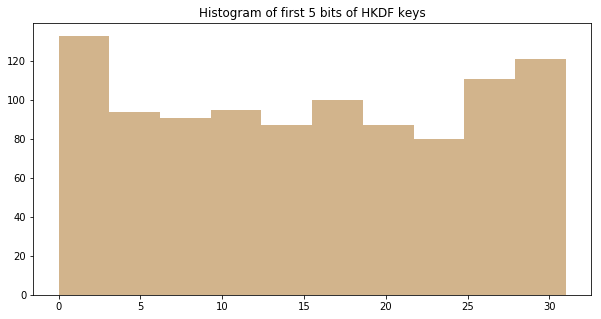

In [8]:
plt.figure(figsize=(10,5))
plt.title('Histogram of first 5 bits of HKDF keys') 
plt.hist(first_bits_of_keys, bins=10, color='tan')
plt.savefig('hists/5_bits_hkdf_keys')

Полученное распределение похоже на равномерное.